In [ ]:
from abscr.omero_connection import connector
from abscr.segmentation import segmentor
import numpy as np
import PIL
from cellpose import io, utils

## Annotate epithelial cells on local image

In [ ]:
image_name = '020_Buccal_05.04.2022_small.jpeg'

image_buccal = PIL.Image.open(image_name)
image_buccal.reduce(4)

In [ ]:
segmentor = segmentor.Segmentor()
segmentation = segmentor.predict_all(image_name, plot_segm=True, savedir='segmentation_results/')

## Create a connection via OmeroClient

Do not forget to change to your username

In [ ]:
user = ''
host = ''
client = connector.OmeroClient(username=user, host=host)

## Set the group id we want to work with

In [ ]:
group_id = 3  # Default group
#group_id = 611  # ABSCR group
client.set_omero_group(group_id)

## Create a new project

In [ ]:
prj_name = 'TestAnnotationProject'
prj_id = client.create_project(project_name=prj_name)
print(prj_id)

## Create a new dataset

In [ ]:
dataset_id = client.create_dataset(dataset_name='TestAnnotationDataset', project_id=prj_id)
print(dataset_id)

## Post a new image to the Omero dataset we just created

Create image array from our test image

In [ ]:
PIL_image = PIL.Image.open(image_name)
test_image = np.asarray(PIL_image)

In [ ]:
test_image = np.expand_dims(test_image, axis=[2,4])
test_image = np.swapaxes(test_image, 0, 1)
test_image.shape

Post the image

In [ ]:
im_id = client.post_image(image_array=test_image, image_name="dummy_image", dataset_id=dataset_id)
print(im_id)

## Post masks to Omero

Get image object first

In [ ]:
img_obj = client.get_image_cursor(im_id)

Render the image

In [ ]:
client.get_image_thumbnail(img_obj, factor=4)

In [ ]:
# img_obj.renderImage(0, 0)

In [ ]:
client.show_img_info(img_obj)

## Masks

Read the masks data from a txt file with results

In [ ]:
outlines_filename = 'segmentation_results/020_Buccal_05.04.2022_small_cp_outlines.txt'
with open(outlines_filename) as f:
    outlines = f.readlines()

Upload to the Omero server

In [ ]:
for i, o in enumerate(outlines):
    coords_flat = np.fromstring(o, sep=',')
    # make pairs x, y
    polyg = [list(x) for x in zip(coords_flat[::2], coords_flat[1::2])]
    # upload to the omero
    roi_ = client.register_shape_to_roi(image=img_obj, polygon=polyg, text=f'epithelial_{i}')

## Now let's check Masks in the Omero web-client

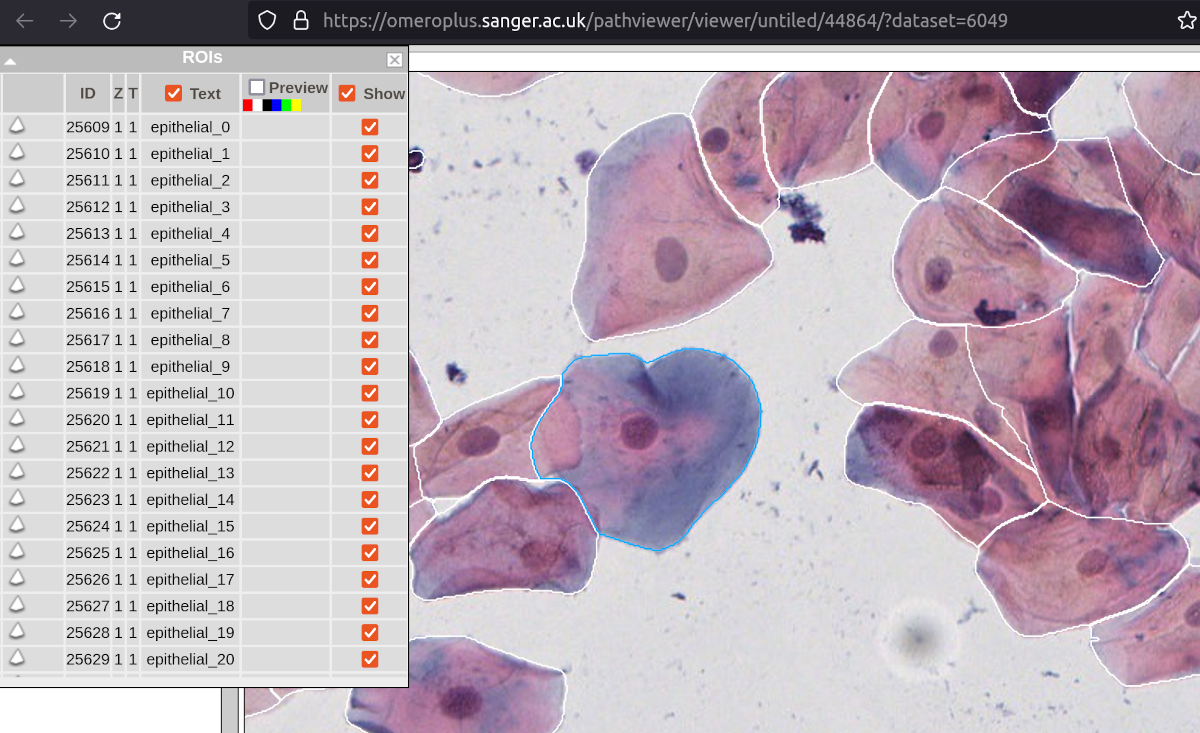

## Close the connection

In [ ]:
client.close()